# Preamble

In [15]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Data Loading

In [2]:
file = h5py.File('0noise_gaussian_O4.h5','r')
Mcz = np.array(file['det_Mc'])
q = np.array(file['q'])
DL = np.array(file['d_L'])
file.close()

In [3]:
Nobs = len(Mcz)

# Pop Cosmo Estimation

# Toy Model I

Here $\vec{\Omega}_P = \{\mu_P, \sigma_P \}$, and $\vec{\Omega}_C = \{H_0, \Omega_M, w \}$.

Under simplified asuumptions:
1. no covariance between $M_{cz}^{obs}$ and $logD_L^{obs}$,
2. $\sigma_{M_{cz}^{obs}} = 0$

$M_{cz}$ integral becomes analytic.

Posterior of $\{\mu_P, \sigma_P, H_0, \Omega_M, w \}$ is,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{logD_L} N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P).dlogD_L
$$

Here we will investigate whether Posterior is more informative than Prior or not.  

Pymc does not have interpolation module, so it is written.

In [4]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Routine for Luminosity Distance

In [5]:
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Cosmological Parameter Estimation by Pymc

A note on the maths:
$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{logD_L} N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P).dlogD_L
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \left\langle \prod_i \int_{logD_L} N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P).dlogD_L \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \left\langle \prod_i \left\langle P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P) , \right\rangle _{logD_L \sim N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}) ~samples} \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \left\langle \prod_i \left\langle P(z(D_L, H_0, \Omega_M, w)).\\
\frac{dz}{dD_L}\Big |_{z(D_L, H_0, \Omega_M, w)}.\frac{dD_L}{dlogD_L}.\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P) \right\rangle _{D_L \sim exp(N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i})) ~samples} \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

Now $z_{nit} = \frac{z(D_L, H_0, \Omega_M, w)}{10}$, gives $P(z(D_L, H_0, \Omega_M, w)) = P(z_{unit})\frac{dz_{unit}}{dz} = P\Big (\frac{z(D_L, H_0, \Omega_M, w)}{10}\Big ).\frac{1}{10}$, and $\frac{dD_L}{dlogD_L}=D_L$. Hence,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \left\langle \prod_i \left\langle P\Big (\frac{z(D_L, H_0, \Omega_M, w)}{10}\Big ).\\
\frac{D_L/10}{\frac{dD_L}{dz}\Big |_{z(D_L, H_0, \Omega_M, w)}}.\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P) \right\rangle _{D_L \sim exp(N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i})) ~samples} \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

where,

$$
D_L = dH.(1+z).\int_0^z \frac{dz^{\prime}}{E(z^{\prime})} \Rightarrow \frac{dD_L}{dz} = \frac{D_L}{1+z} + \frac{dH.(1+z)}{E(z)} ~\Big(\text{Here}, ~dH = \frac{c}{H_0}\Big)
$$

In [6]:
logds = np.log(DL) #log Mpc
Ns = len(DL[0])

In [7]:
wDM = 0

Structure of input data:

Mcz = 

    [[sample1 for event1, sample2 for event1,...,sampleNs for event1],

     [sample1 for event2, sample2 for event2,...,sampleNs for event2],
     
     .
     
     .
     
     .
     
     [sample1 for eventNobs, sample2 for eventNobs,...,sampleNs for eventNobs]]

logds = 
     
     [[sample1 for event1, sample2 for event1,...,sampleNs for event1],

     [sample1 for event2, sample2 for event2,...,sampleNs for event2],
     
     .
     
     .
     
     .
     
     [sample1 for eventNobs, sample2 for eventNobs,...,sampleNs for eventNobs]]

In [8]:
Mczo = np.zeros([Nobs, Ns])

for i in range(Nobs):
    Mczo[i].fill(Mcz[i])

In [9]:
print(Mczo, logds)

[[1.22328685 1.22328685 1.22328685 ... 1.22328685 1.22328685 1.22328685]
 [1.19709519 1.19709519 1.19709519 ... 1.19709519 1.19709519 1.19709519]
 [1.17694205 1.17694205 1.17694205 ... 1.17694205 1.17694205 1.17694205]
 ...
 [1.16227706 1.16227706 1.16227706 ... 1.16227706 1.16227706 1.16227706]
 [1.36277154 1.36277154 1.36277154 ... 1.36277154 1.36277154 1.36277154]
 [1.17927758 1.17927758 1.17927758 ... 1.17927758 1.17927758 1.17927758]] [[5.1824625  4.90936046 4.68092319 ... 5.04609969 4.91555957 5.11467202]
 [4.93549395 5.45197686 5.53969481 ... 5.00907663 4.78148636 5.22197266]
 [4.8031904  4.67780749 4.68283758 ... 4.04671452 3.91284543 3.95021527]
 ...
 [5.30628934 4.6943451  5.2636155  ... 5.14025491 5.35597575 5.15862129]
 [4.48971167 4.91279727 4.97112076 ... 4.6523032  4.64379206 4.74318027]
 [5.15930879 5.28229439 5.2483525  ... 5.18064258 4.99053247 5.23392079]]


In [16]:
dcheck = []
for i in range(Nobs):
    dcheck.append(np.exp(np.mean(logds[i])))
    
dcheck = np.array(dcheck)

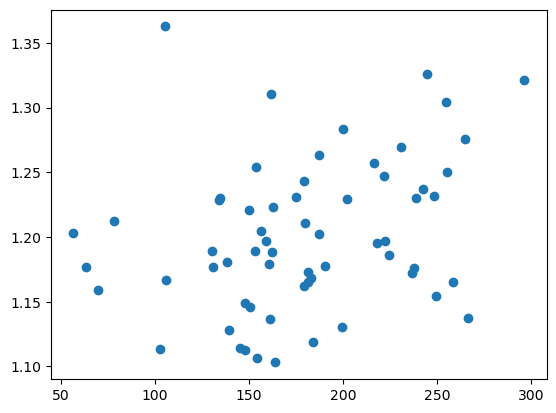

In [17]:
plt.scatter(dcheck, Mcz)

In [18]:
dsplit = np.median(dcheck)

low_d = dcheck < dsplit
high_d = ~low_d

In [22]:
(np.mean(Mcz[low_d])-np.mean(Mcz[high_d]))/np.sqrt(np.var(Mcz[low_d]) + np.var(Mcz[high_d]))*np.sqrt(len(Mcz))

-2.474043318608498

In [20]:
np.std(Mcz[low_d]), np.std(Mcz[high_d])

(0.05778191954125711, 0.055267457519972446)

In [10]:
def make_model(Mczo, logds, zmax=100, Nz=1024):

    zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), Nz))

    with pm.Model() as model:        
        mu_P = pm.Uniform('mu_P', 0.7, 1.7) #in solar mass unit
        sigma_P = pm.Uniform('sigma_P', 0.05, 0.15)

        h = pm.Uniform('h', 0.2, 1.2)
        Om = pm.Uniform('Om', 0.1, 0.5)
        w = pm.Uniform('w', -1.5, -0.5)
        
        dH = pm.Deterministic('dH', 2.99792*(10**3) / h) # Mpc
        
        ds = at.exp(logds)
        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)
        z = at_interp(ds, dLinterp, zinterp)
        z_unit = z/10
        
        var = at.exp(pm.logp(pm.Beta.dist(3, 9), z_unit))
        ddLdz = ds/(1+z)+dH*(1+z)/Ez(z, Om, w, wDM)
        var1 = ds/(10*ddLdz)
        var2 = 1/(1+z)
        Mc = Mczo/(1 + z)
        var3 = at.exp(pm.logp(pm.Normal.dist(mu_P, sigma_P), Mc))
        var4 = at.sum(var*var1*var2*var3, axis=1)
        pm.Potential('pos', at.sum(at.log(var4)))
    return model

In [11]:
tune = 1000
target_accept = 0.99
with make_model(Mczo, logds) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, sigma_P, h, Om, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10668 seconds.


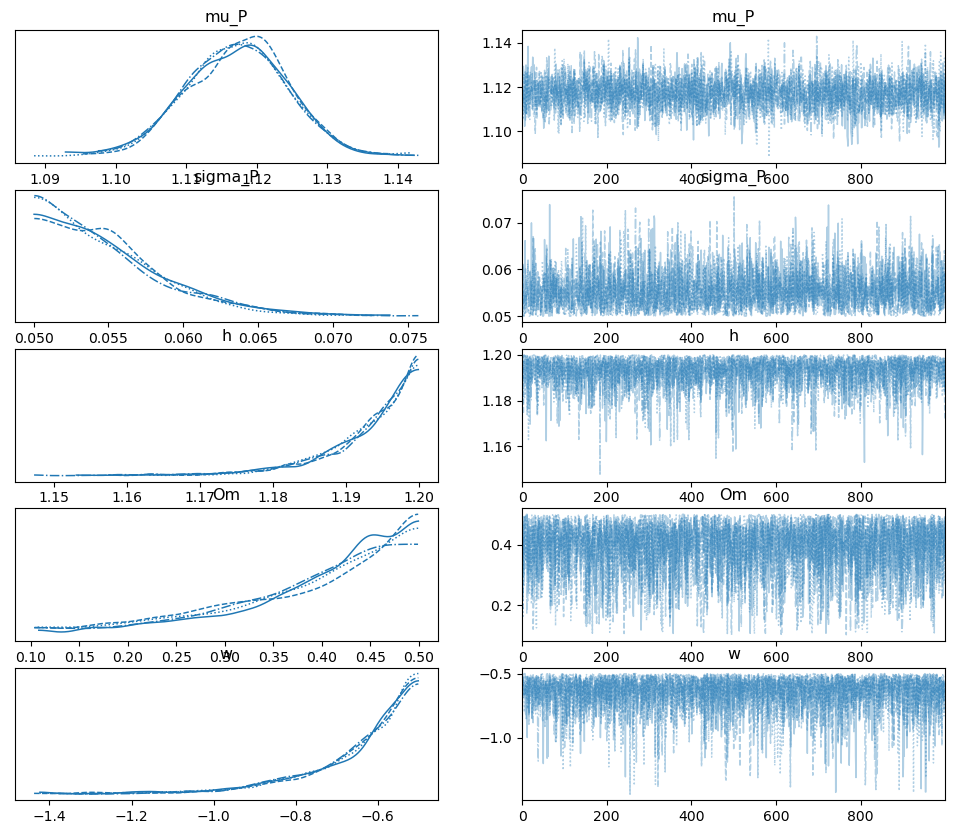

In [12]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'])
    fig = axes.ravel()[0].figure
    fig.savefig('O4.png')

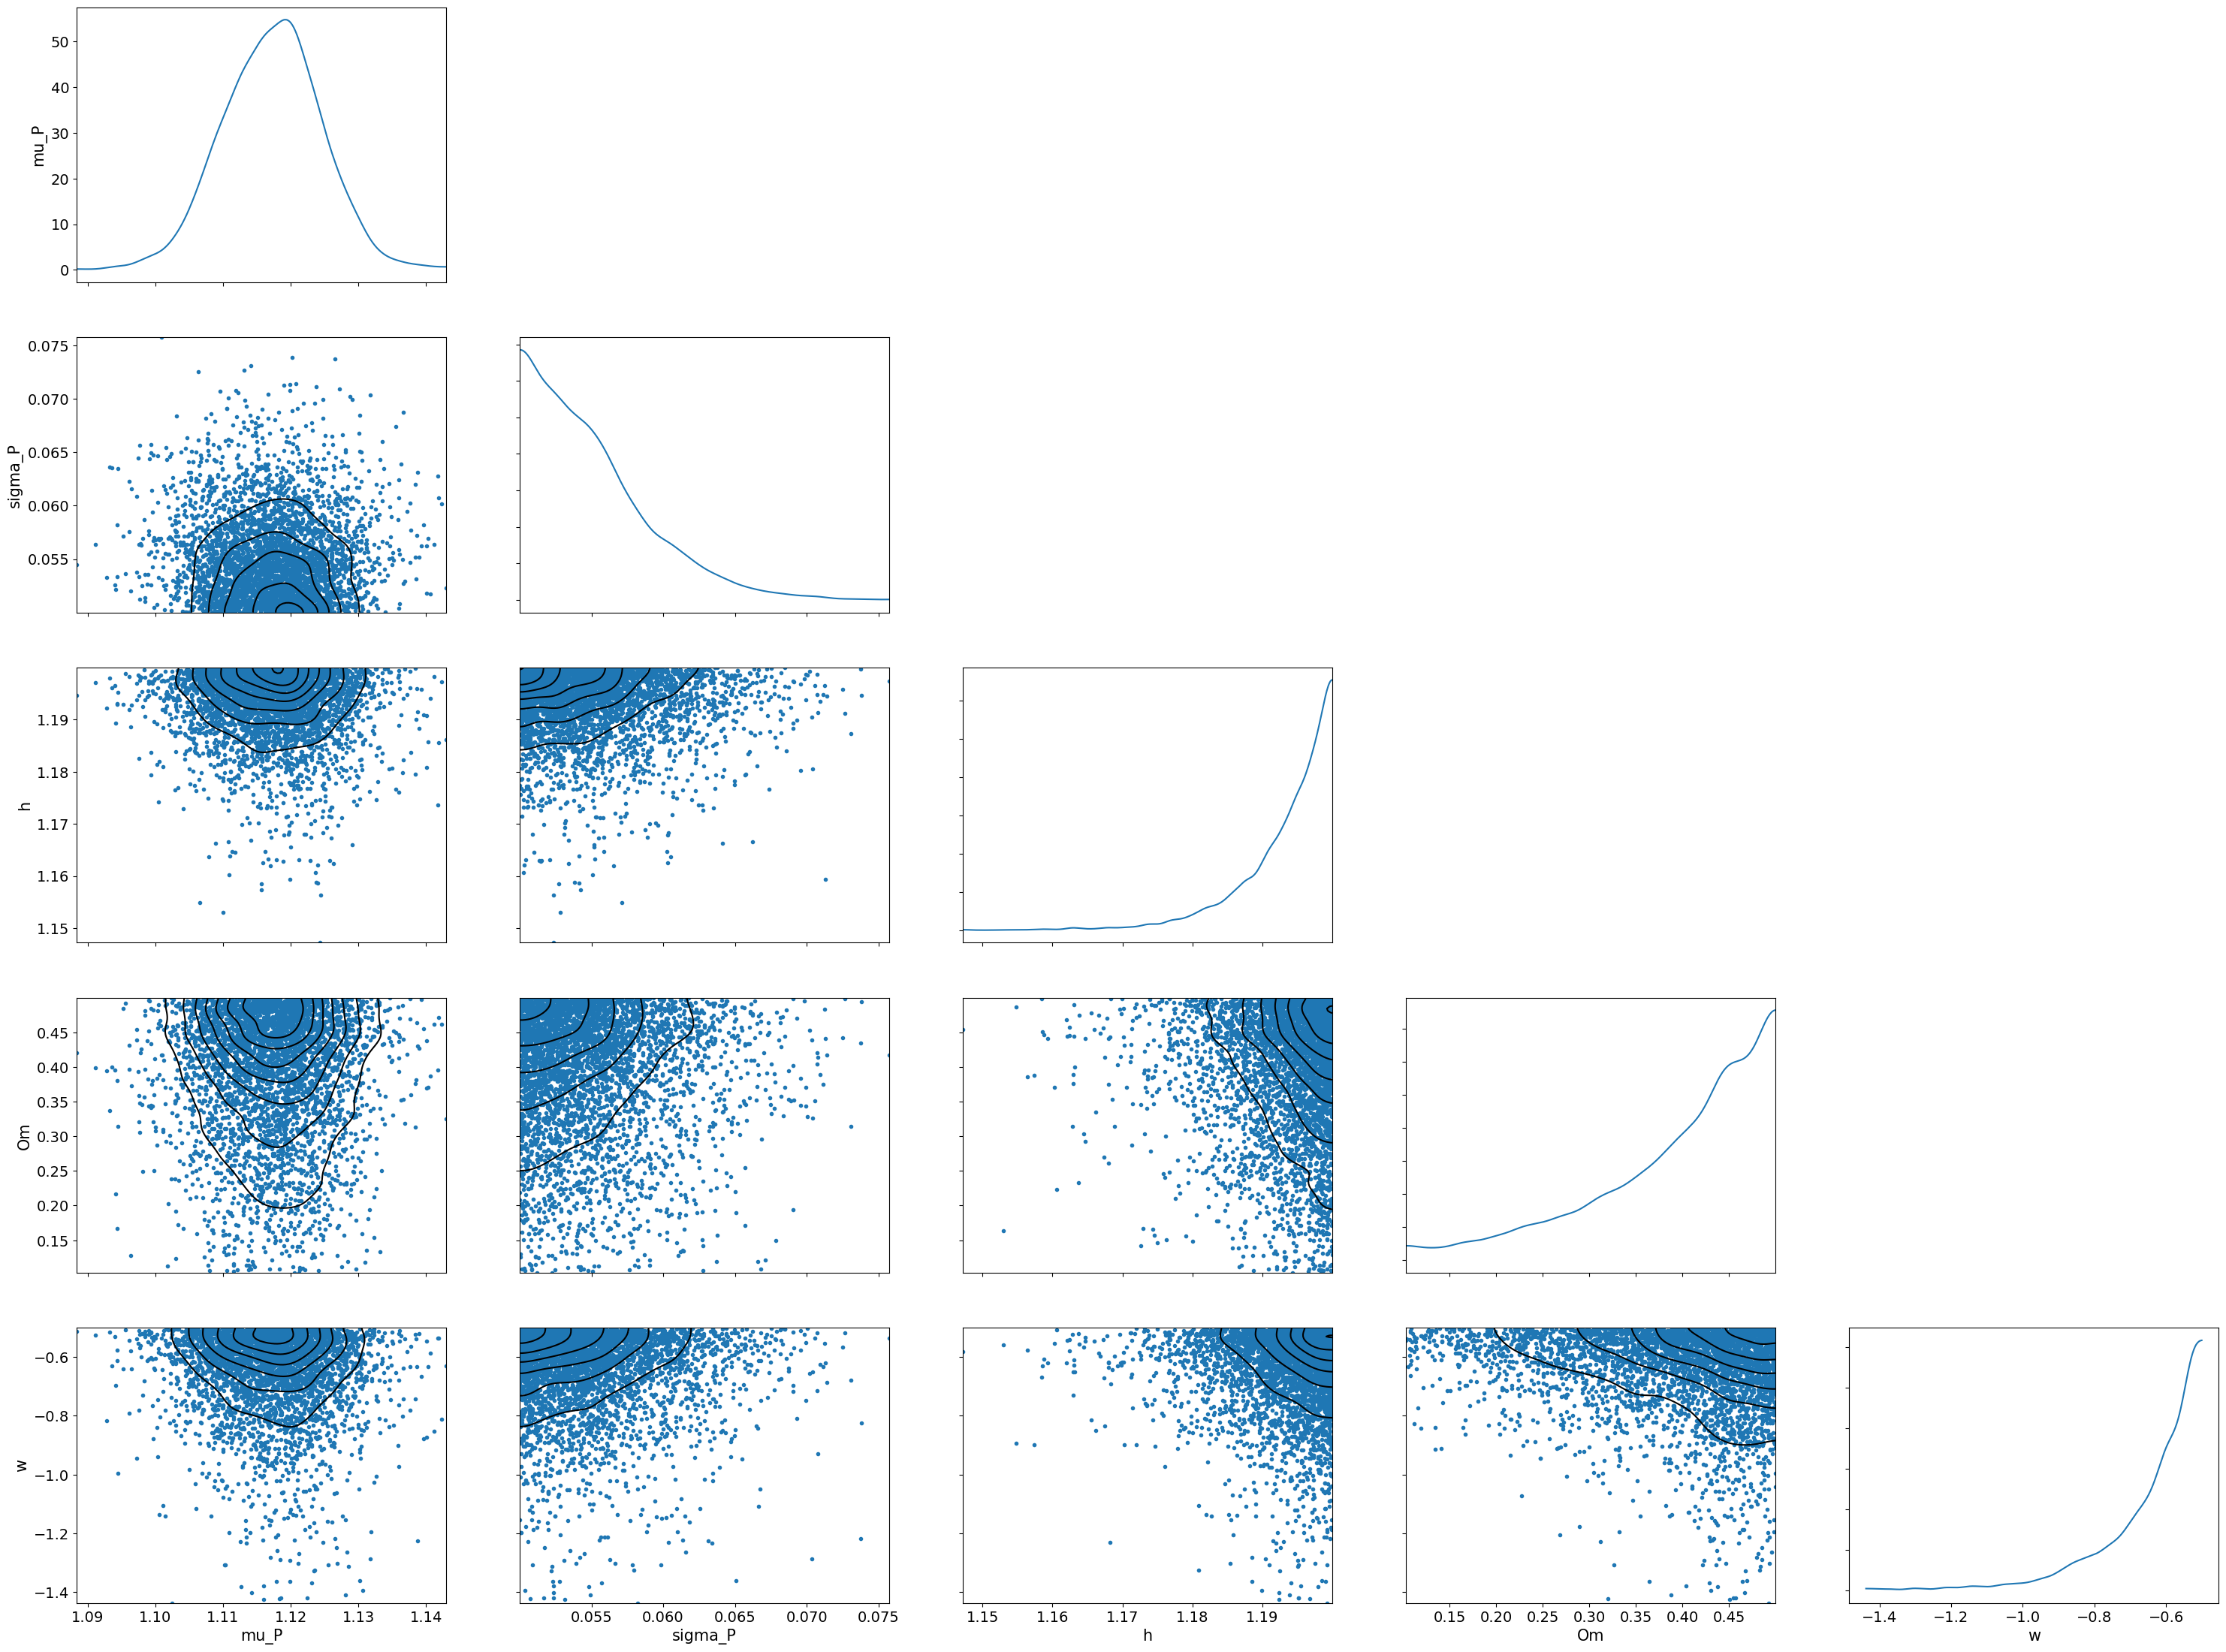

In [13]:
axes = az.plot_pair(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes.ravel()[0].figure
fig.savefig('O4_1.png')

In [14]:
with model:
    display(az.summary(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_P,1.117,0.007,1.104,1.131,0.000,0.000,2600.0,2689.0,1.0
sigma_P,0.055,0.004,0.050,0.063,0.000,0.000,1664.0,1128.0,1.0
h,1.193,0.007,1.181,1.200,0.000,0.000,2494.0,1562.0,1.0
Om,0.392,0.091,0.215,0.500,0.002,0.001,2936.0,2234.0,1.0
w,-0.647,0.147,-0.907,-0.500,0.002,0.002,3817.0,2141.0,1.0
